The point of this notebook is to do a quick prediction on some sample images with a pretrained network.

# Important Imports

In [1]:
import sys

sys.path.append('../')

import cPickle as pickle
import re
import glob
import os
from generators import DataLoader
import time
import holoviews as hv
import theano
import theano.tensor as T
import numpy as np
import pandas as p
import lasagne as nn

from utils import hms, architecture_string, get_img_ids_from_iter

%pylab inline

rcParams['figure.figsize'] = 16, 6
# rcParams['text.color'] = 'red'
# rcParams['xtick.color'] = 'red'
# rcParams['ytick.color'] = 'red'

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

dump_path = '../dumps/2015_07_17_123003.pkl'
model_data = pickle.load(open(dump_path, 'r'))

# Let's set the in and output layers to some local vars.
l_out = model_data['l_out']
l_ins = model_data['l_ins']

chunk_size = model_data['chunk_size'] * 2
batch_size = model_data['batch_size']

#print "Batch size: %i." % batch_size
#print "Chunk size: %i." % chunk_size

output = nn.layers.get_output(l_out, deterministic=True)
input_ndims = [len(nn.layers.get_output_shape(l_in))
               for l_in in l_ins]
xs_shared = [nn.utils.shared_empty(dim=ndim)
             for ndim in input_ndims]
idx = T.lscalar('idx')

givens = {}
for l_in, x_shared in zip(l_ins, xs_shared):
    givens[l_in.input_var] = x_shared[idx * batch_size:(idx + 1) * batch_size]

compute_output = theano.function(
    [idx],
    output,
    givens=givens,
    on_unused_input='ignore'
)

# Do transformations per patient instead?
if 'paired_transfos' in model_data:
    paired_transfos = model_data['paired_transfos']
else:
    paired_transfos = False
    
#print paired_transfos

Using gpu device 0: GeForce GTX 970 (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 4007)
/home/sidharth/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Populating the interactive namespace from numpy and matplotlib


We're going to test on some train images, so loading the training set labels.

# need to repopulate with test

In [2]:
train_labels = p.read_csv('../data/new_trainLabels.csv')

In [3]:
print train_labels.head(20)

             image  level
0   9999_left.jpeg      0
1  9999_right.jpeg      0


In [4]:
# Get all patient ids.
patient_ids = sorted(set(get_img_ids_from_iter(train_labels.image)))

num_chunks = int(np.ceil((2 * len(patient_ids)) / float(chunk_size)))

In [5]:
# Where all the images are located: 
# it looks for [img_dir]/[patient_id]_[left or right].jpeg
img_dir = '../test_resized/'

Using the DataLoader to set up the parameters, you could replace it with something much simpler.

In [6]:
data_loader = DataLoader()
new_dataloader_params = model_data['data_loader_params']
new_dataloader_params.update({'images_test': patient_ids})
new_dataloader_params.update({'labels_test': train_labels.level.values})
new_dataloader_params.update({'prefix_train': img_dir})
data_loader.set_params(new_dataloader_params)

The next function is going to iterate over a test generator to get the outputs.

In [7]:
def do_pred(test_gen):
    outputs = []

    for e, (xs_chunk, chunk_shape, chunk_length) in enumerate(test_gen()):
        num_batches_chunk = int(np.ceil(chunk_length / float(batch_size)))

        print "Chunk %i/%i" % (e + 1, num_chunks)

        print "  load data onto GPU"
        for x_shared, x_chunk in zip(xs_shared, xs_chunk):
            x_shared.set_value(x_chunk)

        print "  compute output in batches"
        outputs_chunk = []
        for b in xrange(num_batches_chunk):
            out = compute_output(b)
            outputs_chunk.append(out)

        outputs_chunk = np.vstack(outputs_chunk)
        outputs_chunk = outputs_chunk[:chunk_length]

        outputs.append(outputs_chunk)

    return np.vstack(outputs), xs_chunk

We get the default "no transformation" parameters for the model.

In [8]:
no_transfo_params = model_data['data_loader_params']['no_transfo_params']

#print no_transfo_params

And set up the test generator on the first 256 patients of the training set (512 images).

In [9]:
# The default gen with "no transfos".
test_gen = lambda: data_loader.create_fixed_gen(
    data_loader.images_test[:128*2],
    chunk_size=chunk_size,
    prefix_train=img_dir,
    prefix_test=img_dir,
    transfo_params=no_transfo_params,
    paired_transfos=paired_transfos,
)

Then we can get some predictions.

In [10]:
%%time
outputs_orig, chunk_orig = do_pred(test_gen)

Chunk 1/1
  load data onto GPU
  compute output in batches
CPU times: user 292 ms, sys: 220 ms, total: 512 ms
Wall time: 512 ms


In [11]:
d={}
for i,patient in zip(range(0,outputs_orig.shape[0],2),patient_ids):
    a=hv.RGB.load_image('../test_resized//'+str(patient)+'_left.jpeg')
    b=hv.RGB.load_image('../test_resized//'+str(patient)+'_right.jpeg')
    a=a + hv.Bars(outputs_orig[i])
    b=b+hv.Bars(outputs_orig[i+1])
    d[patient] = (a+b).cols(2)

In [12]:


hv.notebook_extension()

In [13]:
result=hv.HoloMap(d)

# Legend
--------
 0 - No DR
 
 1 - Mild DR
 
 2 - Moderate DR
 
 3 - Severe DR
 
 4 - PDR

-----
X axis for labels

Y axis for probability

Results are for left and right eyes (A and C respectively)

:HoloMap   [Default]
   :Layout
      .RGB.I    :RGB   [x,y]   (R,G,B)
      .Bars.I   :Bars   [x]   (y)
      .RGB.II   :RGB   [x,y]   (R,G,B)
      .Bars.III :Bars   [x]   (y)
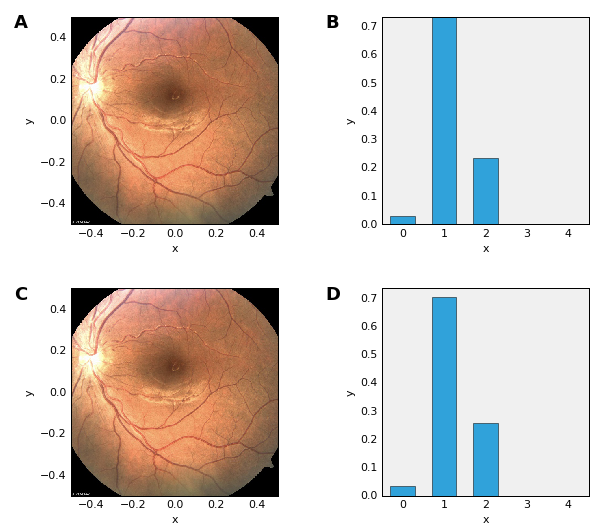

In [14]:
result